In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from utils import get_data, get_continuous_chunks
from tqdm.auto import tqdm

ModuleNotFoundError: No module named 'utils'

In [ ]:
df=get_data()

In [ ]:
df=df[(df.index>='2025-04-24 06:00:00')&(df.index<='2025-04-24 14:00:00')]

In [ ]:
def get_billet_start(signal, baseline=700):
    up_mask = (signal == baseline) & (signal.shift(-1) > baseline)
    up_transitions = signal[up_mask].index
    return up_transitions

def get_billet_end(signal, baseline=700):
    mask = (signal == baseline) & (signal.shift(1) > baseline)
    transition_idx = signal[mask].index
    return transition_idx

In [ ]:
stand1 = df.loc[:,'[13:0]']

In [ ]:
start_times = get_billet_start(stand1)
end_times = get_billet_end(stand1)

In [ ]:
billets_groups = []
for start_time, end_time in zip(start_times, end_times[1:]):
    if end_time > start_time and (end_time - start_time).total_seconds() < 50:
        s = start_time + pd.Timedelta(milliseconds=100)
        e = end_time - pd.Timedelta(milliseconds=100)
        d = (e-s).total_seconds()
        billets_groups.append({
            'start':s,
            'end':e,
            'duration':d
        })

In [ ]:
len(billets_groups)

604

In [ ]:
billets_groups[0]

{'start': Timestamp('2025-04-24 06:00:22.273616'),
 'end': Timestamp('2025-04-24 06:00:45.723616'),
 'duration': 23.45}

In [ ]:
def plot_billet(signal, group):
    start, end = group['start'], group['end']
    plt.figure(figsize=(12,3))
    plt.plot(signal.loc[start:end])
    plt.title(f"duration: {group['duration']:.2f}")
    plt.show()

In [ ]:
def get_billet_info(signal, group):
    time = lambda x : (x.index[-1] - x.index[0]).total_seconds()
    start, end, duration = group['start'], group['end'],group['duration']
    head_start = start
    head_end = start + pd.Timedelta(seconds=0.08*duration)
    tail_end = end
    tail_start = end - pd.Timedelta(seconds=0.08*duration)
    head_data = signal[(signal.index>=head_start) & (signal.index<=head_end)]
    stable_data = signal[(signal.index>head_end) & (signal.index<tail_start)]
    tail_data = signal[(signal.index>=tail_start) & (signal.index<=tail_end)]
    # print(f"head: {time(head_data)}, tail: {time(tail_data)}, stable: {time(stable_data)}")
    head_data_stats = {f"head_{s}":v for s,v in head_data.describe().to_dict().items() if all(x not in s for x in ['count','%'])}
    tail_data_stats = {f"tail_{s}":v for s,v in tail_data.describe().to_dict().items() if all(x not in s for x in ['count','%'])}
    stable_data_stats = {f"stable_{s}":v for s,v in stable_data.describe().to_dict().items() if all(x not in s for x in ['count','%'])}
    stable_data_stats = dict()
    for stable_idx, stable_batch in enumerate(np.array_split(stable_data,5)):
        stable_batch_stats = {f"stable_{stable_idx}_{s}":v for s,v in stable_batch.describe().to_dict().items() if all(x not in s for x in ['count','%'])}
        stable_data_stats.update(stable_batch_stats)

    return {'start':start,'end':end,**head_data_stats,**stable_data_stats,**tail_data_stats}

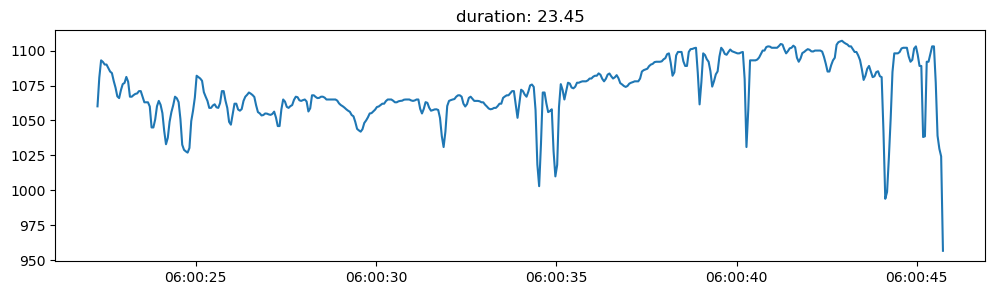

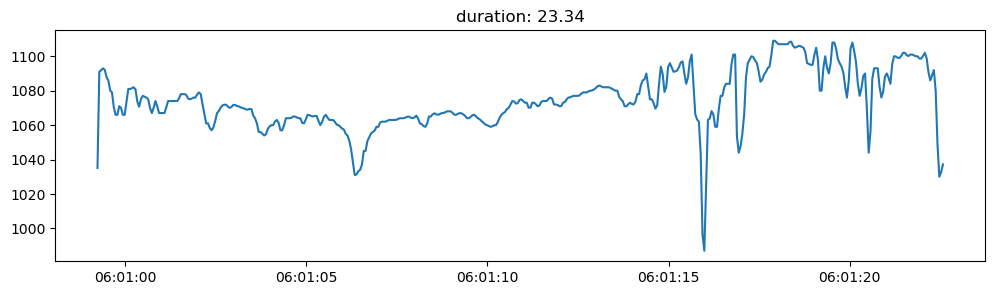

In [ ]:
for idx, billet_group in enumerate(billets_groups):
    plot_billet(stand1, billet_group)
    if idx==1:
        break

In [ ]:
billet_stats = [get_billet_info(stand1,group) for group in tqdm(billets_groups)]

  0%|          | 0/604 [00:00<?, ?it/s]

In [ ]:
stats = pd.DataFrame(billet_stats)

In [ ]:
stats.shape

(604, 30)

In [ ]:
stats

,start,end,head_mean,head_std,head_min,head_max,stable_0_mean,stable_0_std,stable_0_min,stable_0_max,...,stable_3_min,stable_3_max,stable_4_mean,stable_4_std,stable_4_min,stable_4_max,tail_mean,tail_std,tail_min,tail_max
0,2025-04-24 06:00:22.273616,2025-04-24 06:00:45.723616,1069.814008,12.939310,1042.6000,1093.0,1058.637604,11.398204,1027.0,1082.0,...,1061.5,1102.0000,1095.786717,11.005040,1031.0,1107.0,1073.147126,36.968036,956.8000,1103.0000
1,2025-04-24 06:00:59.238548,2025-04-24 06:01:22.575304,1074.602316,10.480166,1035.1428,1093.0,1067.203465,6.858183,1054.0,1079.0,...,987.0,1101.0000,1092.858955,15.801483,1044.0,1109.0,1088.389900,19.364345,1030.0000,1102.0000
2,2025-04-24 06:01:35.725304,2025-04-24 06:01:59.173255,1076.368363,16.148232,989.5000,1092.0,1069.652404,7.079918,1051.0,1082.0,...,984.0,1103.5714,1097.219014,13.092931,1051.0,1112.0,1071.994571,33.531474,923.3000,1104.0000
3,2025-04-24 06:02:20.367346,2025-04-24 06:02:43.867346,1080.143337,5.667185,1067.0000,1089.0,1070.365023,7.661511,1052.0,1084.0,...,975.0,1105.0000,1100.651208,15.302309,1049.0,1118.8,1060.961168,80.472811,734.0000,1107.0000
4,2025-04-24 06:02:59.859969,2025-04-24 06:03:23.337912,1064.784018,60.505393,731.0000,1088.0,1069.037082,7.514884,1052.0,1081.0,...,1002.0,1108.0000,1100.704121,9.983768,1074.0,1115.0,1084.111458,23.151675,1038.0000,1110.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
599,2025-04-24 13:45:52.333205,2025-04-24 13:46:15.783205,1054.105442,57.185268,740.5000,1075.0,1066.632959,4.790051,1056.0,1074.0,...,1046.0,1075.7142,1063.317583,4.198260,1047.2,1071.0,1035.492082,74.510116,729.5000,1077.2858
600,2025-04-24 13:46:29.295536,2025-04-24 13:46:52.862423,1065.253800,5.043528,1056.0000,1079.0,1062.497146,8.223580,1041.0,1076.0,...,1048.0,1078.1111,1055.581500,13.653671,1005.0,1071.0,1028.058574,84.999233,730.7500,1080.0000
601,2025-04-24 13:47:06.162423,2025-04-24 13:47:29.740507,1065.116084,11.975771,999.2000,1076.0,1064.188792,4.568922,1054.0,1073.0,...,1057.0,1074.0000,1064.899762,10.244918,1026.0,1076.0,1058.870179,13.951681,1005.1429,1079.0000
602,2025-04-24 13:47:43.490507,2025-04-24 13:48:06.990655,1066.373945,5.562361,1053.6000,1080.0,1062.588676,5.581971,1051.0,1072.0,...,1052.0,1072.8000,1055.398447,8.104704,1042.0,1073.0,1051.738875,12.807663,1006.0000,1066.0000


In [ ]:
groups = stats.groupby(pd.Grouper(freq='57min',key='start'))
chunks = [c[1] for c in groups]

In [ ]:
stats.to_csv('billet-profile_24-04-2025_A-SHIFT_16mm_STAND1_ENTRY.csv',index=False)